## Specify variables for the analysis: 
    - Data (mouse, day, sessions)
    - Neuron type: excit, inhibit, or all
    - Current-choice or previous-choice SVM training
        if current-choice, specify epoch of training, the outcome (corr, incorr, all) and strength (easy, medium, hard, all) of trials for training SVM.
        if previous-choice, specify ITI flag
    - Trials that will be used for projections and class accuracy traces (corr, incorr, all, trained).

In [1]:
# Add the option to toggle on/off the raw code. Copied from http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [23]:
mousename = 'fni17'
imagingFolder = '151028'
mdfFileNumber = [1,2,3] 
pnev2load = [] #[] [3] # which pnev file to load: indicates index of date-sorted files: use 0 for latest. Set [] to load the latest one.

saveResults = 0; # save results in mat file.
trialHistAnalysis = 0; 
neuronType = 2; # 0: excitatory, 1: inhibitory, 2: all types.

if trialHistAnalysis==1: # more parameters are specified in popClassifier_trialHistory.m
    iTiFlg = 1; # 0: short ITI, 1: long ITI, 2: all ITIs.
    epEnd_rel2stimon_fr = 0 # 3; # -2 # epEnd = eventI + epEnd_rel2stimon_fr
else:
    ep_ms = [1000, 1300] # [1000, 1300]; #[700, 900]; # [500, 700]; # training epoch relative to stimOnset % we want to decode animal's upcoming choice by traninig SVM for neural average responses during ep ms after stimulus onset.
    # outcome2ana will be used if trialHistAnalysis is 0. When it is 1, by default we are analyzing past correct trials. If you want to change that, set it in the matlab code.
    outcome2ana = 'corr' # '', corr', 'incorr' # trials to use for SVM training (all, correct or incorrect trials)
    strength2ana = 'all' # 'all', easy', 'medium', 'hard' % What stim strength to use for training?
    thStimStrength = 3; # 2; # threshold of stim strength for defining hard, medium and easy trials.

trs4project = 'trained' # 'trained', 'all', 'corr', 'incorr' # trials that will be used for projections and the class accuracy trace; if 'trained', same trials that were used for SVM training will be used. "corr" and "incorr" refer to current trial's outcome, so they don't mean much if trialHistAnalysis=1. 
windowAvgFlg = 1 # if 0, data points during ep wont be averaged when setting X (for SVM training), instead each frame of ep will be treated as a separate datapoint. It helps with increasing number of datapoints, but will make data mor enoisy.

thAct = 5e-4; # 1e-5 # neurons whose average activity during ep is less than thAct will be called non-active and will be excluded.
thTrsWithSpike = 1; # 3 % remove neurons that are active in <thSpTr trials.

numSamples = 100; # number of iterations for finding the best c (inverse of regularization parameter)


##
if neuronType==0:
    ntName = 'excit'
elif neuronType==1:
    ntName = 'inhibit'
elif neuronType==2:
    ntName = 'all'     

if trialHistAnalysis==1:    
    if iTiFlg==0:
        itiName = 'short'
    elif iTiFlg==1:
        itiName = 'long'
    elif iTiFlg==2:
        itiName = 'all'        
    
print 'Analyzing %s' %(mousename+'_'+imagingFolder+'_'+str(mdfFileNumber)) 
if trialHistAnalysis==0:
    print 'Training %s trials of strength %s. Making projections for %s trials' %(outcome2ana, strength2ana, trs4project)
print 'trialHistAnalysis = %i' %(trialHistAnalysis)
print 'Analyzing %s neurons' %(ntName)
if trialHistAnalysis==1:
    print 'Analyzing %s ITIs' %(itiName)
print 'windowAvgFlg = %i' %(windowAvgFlg)
print 'numSamples = %i' %(numSamples)


Analyzing fni17_151028_[1, 2, 3]
Training  trials of strength all. Making projections for trained trials
trialHistAnalysis = 0
Analyzing all neurons
windowAvgFlg = 1
numSamples = 100


## Import Libraries and Modules

In [24]:
import scipy.io as scio
import scipy as sci
import scipy.stats as stats
import numpy as np
import numpy.random as rng

from crossValidateModel import crossValidateModel
from linearSVM import linearSVM
from compiler.ast import flatten
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (6,4) #(8,5)
from IPython.display import display
import sklearn.svm as svm
import os
import glob

import sys
# print sys.path
sys.path.append('/home/farznaj/Documents/trial_history/imaging') # Gamal's dir needs to be added using "if" that takes the value of pwd
# print sys.path

In [25]:
# Extend the built in two tailed ttest function to one-tailed
def ttest2(a, b, **tailOption):
    import scipy.stats as stats
    h, p = stats.ttest_ind(a, b)
    d = np.mean(a)-np.mean(b)
    if tailOption.get('tail'):
        tail = tailOption.get('tail').lower()
        if tail == 'right':
            p = p/2.*(d>0)+(1-p/2.)*(d<0)
        elif tail == 'left':
            p = (1-p/2.)*(d>0)+p/2.*(d<0)
    if d==0:
        p = 1;
    return p

## Set mat-file names

In [26]:
pnev2load = [] #[] [3] # which pnev file to load: indicates index of date-sorted files: use 0 for latest. Set [] to load the latest one.
signalCh = [2] # since gcamp is channel 2, should be always 2.
postNProvided = 1; # If your directory does not contain pnevFile and instead it contains postFile, set this to 1 to get pnevFileName

from setImagingAnalysisNamesP import *

imfilename, pnevFileName = setImagingAnalysisNamesP(mousename, imagingFolder, mdfFileNumber, signalCh=signalCh, pnev2load=pnev2load, postNProvided=postNProvided)

postName = os.path.join(os.path.dirname(pnevFileName), 'post_'+os.path.basename(pnevFileName))
moreName = os.path.join(os.path.dirname(pnevFileName), 'more_'+os.path.basename(pnevFileName))

print(imfilename)
print(pnevFileName)
print(postName)
print(moreName)


/home/farznaj/Shares/Churchland/data/fni17/imaging/151028/151028_001-002-003.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151028/151028_001-002-003_ch2-PnevPanResults-161005-142715.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151028/post_151028_001-002-003_ch2-PnevPanResults-161005-142715.mat
/home/farznaj/Shares/Churchland/data/fni17/imaging/151028/more_151028_001-002-003_ch2-PnevPanResults-161005-142715.mat


## Load matlab variables: event-aligned traces, inhibitRois, outcomes, and responses
    - traces are set in set_aligned_traces.m matlab script.

(79, 451, 271)
No trials with go tone before the end of ep. Good :)
minStimDurNoGoTone = 738.83 ms
No trials with stimDur-without-goTone < 800ms. Good :)
Final: 0 trials excluded in traces_al_stim
(79, 451, 271)
training epoch, rel2 stimOnset, is [ 1003.  1036.  1068.  1100.  1133.  1165.  1197.  1230.  1262.  1294.
  1327.] ms


/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in less_equal
/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in less


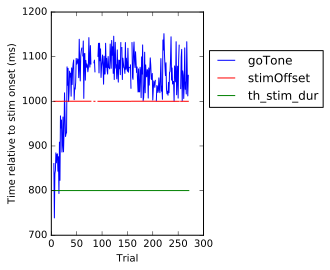

In [27]:
# Set traces_al_stim that is same as traces_al_stimAll except that in traces_al_stim some trials are set to nan, bc their stim duration is < 
# th_stim_dur = 800ms or bc their go tone happens before ep(end)=700ms. But in traces_al_stimAll, all trials are included. 
# You need traces_al_stim for decoding the upcoming choice bc you average responses during ep and you want to 
# control for what happens there. But for trial-history analysis you average responses before stimOnset, so you 
# don't care about when go tone happened or how long the stimulus was. 

frameLength = 1000/30.9; # sec.
    
Data = scio.loadmat(postName, variable_names=['timeCommitCL_CR_Gotone', 'timeStimOnset', 'timeStimOffset'])
timeCommitCL_CR_Gotone = np.array(Data.pop('timeCommitCL_CR_Gotone')).flatten().astype('float')
timeStimOnset = np.array(Data.pop('timeStimOnset')).flatten().astype('float')
timeStimOffset = np.array(Data.pop('timeStimOffset')).flatten().astype('float')

# Load stim-aligned_allTrials traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['stimAl_allTrs'],squeeze_me=True,struct_as_record=False)
eventI = Data['stimAl_allTrs'].eventI - 1 # remember difference indexing in matlab and python!
traces_al_stimAll = Data['stimAl_allTrs'].traces.astype('float')
time_aligned_stim = Data['stimAl_allTrs'].time.astype('float')
# time_aligned_stimAll = Data['stimAl_allTrs'].time.astype('float') # same as time_aligned_stim

print(np.shape(traces_al_stimAll))
DataS = Data
    
    
# ep_ms = [1000, 1200]
if trialHistAnalysis==1:
    traces_al_stim = traces_al_stimAll
    
else:
    # Make sure in none of the trials Go-tone happened before the end of ep:
    i = timeCommitCL_CR_Gotone <= ep_ms[-1];
    if np.sum(i)>0:
        print 'Excluding %i trials from timeStimOnset bc their goTone is earlier than ep end' %(np.sum(i))
    #     timeStimOnset[i] = np.nan;  # by setting to nan, the aligned-traces of these trials will be computed as nan.
    else:
        print('No trials with go tone before the end of ep. Good :)')



    # % Make sure trials that you use for SVM (decoding upcoming choice from
    # % neural responses during stimulus) have a certain stimulus duration. Of
    # % course stimulus needs to at least continue until the end of ep. 
    # % go with either 900 or 800ms. Since the preference is to have at least
    # % ~100ms after ep which contains stimulus and without any go tones, go with 800ms
    # % bc in many sessions go tone happened early... so you will loose lots of
    # % trials if you go with 900ms.

    th_stim_dur = 800; # min stim duration to include a trial in timeStimOnset

    plt.figure
    plt.subplot(1,2,1)
    plt.plot(timeCommitCL_CR_Gotone - timeStimOnset, label = 'goTone')
    plt.plot(timeStimOffset - timeStimOnset, 'r', label = 'stimOffset')
    plt.plot([1, np.shape(timeCommitCL_CR_Gotone)[0]],[th_stim_dur, th_stim_dur], 'g', label = 'th_stim_dur')
    plt.xlabel('Trial')
    plt.ylabel('Time relative to stim onset (ms)')
    plt.legend(loc='center left', bbox_to_anchor=(1, .7)) 
    minStimDurNoGoTone = np.nanmin(timeCommitCL_CR_Gotone - timeStimOnset); # this is the duration after stim onset during which no go tone occurred for any of the trials.
    print 'minStimDurNoGoTone = %.2f ms' %minStimDurNoGoTone


    # exclude trials whose stim duration was < th_stim_dur
    j = (timeStimOffset - timeStimOnset) < th_stim_dur;
    if np.sum(j)>0:
        print 'Excluding %i trials from timeStimOnset bc their stimDur-without-goTone < 800ms' %np.sum(j)
    #     timeStimOnset[j] = np.nan;
    else:
        print 'No trials with stimDur-without-goTone < 800ms. Good :)'



    # Set trials to be removed from traces_al_stimAll    
    toRmv = (i+j)!=0;    
    print 'Final: %i trials excluded in traces_al_stim' %np.sum(toRmv)

    # Set traces_al_stim for SVM classification of current choice. 
    traces_al_stim = traces_al_stimAll
    traces_al_stim[:,:,toRmv] = np.nan
    print(np.shape(traces_al_stim))


    # Set ep
    '''
    if len(ep_ms)==0: # load ep from matlab
        # Load stimulus-aligned traces, frames, frame of event of interest, and epoch over which we will average the responses to do SVM analysis
        Data = scio.loadmat(postName, variable_names=['stimAl'],squeeze_me=True,struct_as_record=False)
        # eventI = Data['stimAl'].eventI - 1 # remember difference indexing in matlab and python!
        # traces_al_stim = Data['stimAl'].traces.astype('float') # traces_al_stim
        # time_aligned_stim = Data['stimAl'].time.astype('float')

        ep = Data['stimAl'].ep - 1
        ep_ms = np.round((ep-eventI)*frameLength).astype(int)
        
    else: # set ep here:
    '''    
    epStartRel2Event = np.ceil(ep_ms[0]/frameLength); # the start point of the epoch relative to alignedEvent for training SVM. (500ms)
    epEndRel2Event = np.ceil(ep_ms[1]/frameLength); # the end point of the epoch relative to alignedEvent for training SVM. (700ms)
    ep = np.arange(eventI+epStartRel2Event, eventI+epEndRel2Event+1).astype(int); # frames on stimAl.traces that will be used for trainning SVM.
    
    print 'training epoch, rel2 stimOnset, is {} ms'.format(np.round((ep-eventI)*frameLength))



In [28]:
# Load 1stSideTry-aligned traces, frames, frame of event of interest
# use firstSideTryAl_COM to look at changes-of-mind (mouse made a side lick without committing it)
Data = scio.loadmat(postName, variable_names=['firstSideTryAl'],squeeze_me=True,struct_as_record=False)
traces_al_1stSide = Data['firstSideTryAl'].traces.astype('float')
time_aligned_1stSide = Data['firstSideTryAl'].time.astype('float')
print(np.shape(traces_al_1stSide))


# Load goTone-aligned traces, frames, frame of event of interest
# use goToneAl_noStimAft to make sure there was no stim after go tone.
Data = scio.loadmat(postName, variable_names=['goToneAl'],squeeze_me=True,struct_as_record=False)
traces_al_go = Data['goToneAl'].traces.astype('float')
time_aligned_go = Data['goToneAl'].time.astype('float')
print(np.shape(traces_al_go))


# Load reward-aligned traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['rewardAl'],squeeze_me=True,struct_as_record=False)
traces_al_rew = Data['rewardAl'].traces.astype('float')
time_aligned_rew = Data['rewardAl'].time.astype('float')
print(np.shape(traces_al_rew))


# Load commitIncorrect-aligned traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['commitIncorrAl'],squeeze_me=True,struct_as_record=False)
traces_al_incorrResp = Data['commitIncorrAl'].traces.astype('float')
time_aligned_incorrResp = Data['commitIncorrAl'].time.astype('float')
print(np.shape(traces_al_incorrResp))


# Load initiationTone-aligned traces, frames, frame of event of interest
Data = scio.loadmat(postName, variable_names=['initToneAl'],squeeze_me=True,struct_as_record=False)
traces_al_init = Data['initToneAl'].traces.astype('float')
time_aligned_init = Data['initToneAl'].time.astype('float')
print(np.shape(traces_al_init))
DataI = Data

if trialHistAnalysis:
    # either of the two below (stimulus-aligned and initTone-aligned) would be fine
#     eventI = DataI['initToneAl'].eventI
    eventI = DataS['stimAl_allTrs'].eventI    
    epEnd = eventI + epEnd_rel2stimon_fr #- 2 # to be safe for decoder training for trial-history analysis we go upto the frame before the stim onset
#     epEnd = DataI['initToneAl'].eventI - 2 # to be safe for decoder training for trial-history analysis we go upto the frame before the initTone onset
    ep = np.arange(epEnd+1)
    print 'training epoch is {} ms'.format(np.round((ep-eventI)*frameLength))
    
    

# Load inhibitRois
Data = scio.loadmat(moreName, variable_names=['inhibitRois'])
inhibitRois = Data.pop('inhibitRois')[0,:]
# print '%d inhibitory, %d excitatory; %d unsure class' %(np.sum(inhibitRois==1), np.sum(inhibitRois==0), np.sum(np.isnan(inhibitRois)))

    
# Set traces for specific neuron types: inhibitory, excitatory or all neurons
if neuronType!=2:    
    nt = (inhibitRois==neuronType) # 0: excitatory, 1: inhibitory, 2: all types.
    # good_excit = inhibitRois==0;
    # good_inhibit = inhibitRois==1;        
    
    traces_al_stim = traces_al_stim[:, nt, :];
    traces_al_1stSide = traces_al_1stSide[:, nt, :];
    traces_al_go = traces_al_go[:, nt, :];
    traces_al_rew = traces_al_rew[:, nt, :];
    traces_al_incorrResp = traces_al_incorrResp[:, nt, :];
    traces_al_init = traces_al_init[:, nt, :];
    traces_al_stimAll = traces_al_stimAll[:, nt, :];
else:
    nt = np.arange(np.shape(traces_al_1stSide)[1])    
    
    
    
# Load outcomes and allResp_HR_LR
# if trialHistAnalysis==0:
Data = scio.loadmat(postName, variable_names=['outcomes', 'allResp_HR_LR'])
outcomes = (Data.pop('outcomes').astype('float'))[0,:]
# allResp_HR_LR = (Data.pop('allResp_HR_LR').astype('float'))[0,:]
allResp_HR_LR = np.array(Data.pop('allResp_HR_LR')).flatten().astype('float')
# choiceVecAll = allResp_HR_LR;  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.    
# choiceVecAll = np.transpose(allResp_HR_LR);  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.    
print '%d correct choices; %d incorrect choices' %(sum(outcomes==1), sum(outcomes==0))



# Set trials strength and identify trials with stim strength of interest
if trialHistAnalysis==0:
    Data = scio.loadmat(postName, variable_names=['stimrate', 'cb'])
    stimrate = np.array(Data.pop('stimrate')).flatten().astype('float')
    cb = np.array(Data.pop('cb')).flatten().astype('float')

    s = stimrate-cb; # how far is the stimulus rate from the category boundary?
    if strength2ana == 'easy':
        str2ana = (abs(s) >= (max(abs(s)) - thStimStrength));
    elif strength2ana == 'hard':
        str2ana = (abs(s) <= thStimStrength);
    elif strength2ana == 'medium':
        str2ana = ((abs(s) > thStimStrength) & (abs(s) < (max(abs(s)) - thStimStrength))); 
    else:
        str2ana = np.full((1, np.shape(outcomes)[0]), True, dtype=bool).flatten();

    print 'Number of trials with stim strength of interest = %i' %(str2ana.sum())
    print 'Stim rates for training = {}'.format(np.unique(stimrate[str2ana]))

    '''
    # Set to nan those trials in outcomes and allRes that are nan in traces_al_stim
    I = (np.argwhere((~np.isnan(traces_al_stim).sum(axis=0)).sum(axis=1)))[0][0] # first non-nan neuron
    allTrs2rmv = np.argwhere(sum(np.isnan(traces_al_stim[:,I,:])))
    print(np.shape(allTrs2rmv))

    outcomes[allTrs2rmv] = np.nan
    allResp_HR_LR[allTrs2rmv] = np.nan
    '''

(81, 451, 271)
(73, 451, 271)
(83, 451, 271)
(127, 451, 271)
(31, 451, 271)
207 correct choices; 42 incorrect choices
Number of trials with stim strength of interest = 271
Stim rates for training = [  6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.
  21.  22.  23.  24.  25.  26.  27.]


## Set X (trials x neurons) and Y (trials x 1) for training the SVM classifier.
    X matrix (size trials x neurons) that contains neural responses at different trials.
    Y choice of high rate (modeled as 1) and low rate (modeled as 0)

In [29]:
# Set Y: the response vector

if trialHistAnalysis:
    # Load trialHistory structure
    Data = scio.loadmat(postName, variable_names=['trialHistory'],squeeze_me=True,struct_as_record=False)
    choiceVec0All = Data['trialHistory'].choiceVec0.astype('float')
    choiceVec0 = choiceVec0All[:,iTiFlg] # choice on the previous trial for short (or long or all) ITIs
else: # set choice for the current trial
    choiceVec0 = allResp_HR_LR;  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.    
#     choiceVec0 = np.transpose(allResp_HR_LR);  # trials x 1;  1 for HR choice, 0 for LR choice. % choice of the current trial.    
    if outcome2ana == 'corr':
        choiceVec0[outcomes!=1] = np.nan; # analyze only correct trials.
    elif outcome2ana == 'incorr':
        choiceVec0[outcomes!=0] = np.nan; # analyze only incorrect trials.   
    
    choiceVec0[~str2ana] = np.nan   
# Y = choiceVec0
# print(choiceVec0.shape)


# Set X: the predictor matrix (trials x neurons) that shows average of spikes for a particular epoch for each trial and neuron.

if trialHistAnalysis:
    # either of the two cases below should be fine (init-aligned traces or stim-aligned traces.)
    spikeAveEp0 = np.transpose(np.nanmean(traces_al_stimAll[ep,:,:], axis=0)) # trials x neurons    
#     spikeAveEp0 = np.transpose(np.nanmean(traces_al_init[ep,:,:], axis=0)) # trials x neurons    
else:    
    spikeAveEp0 = np.transpose(np.nanmean(traces_al_stim[ep,:,:], axis=0)) # trials x neurons    

# X = spikeAveEp0;
print(spikeAveEp0.shape)


(271, 451)


115 high-rate trials, and 134 low-rate trials

NsExcluded not saved, so setting it here
	60 neurons with ave activity in ep < 0.00050
	0 neurons are active in < 1 trials
60 = Final # non-active neurons
	original # neurons = 451; fraction excluded = 0.13

52, 374, 25: #original inh, excit, unsure
4, 51, 5: #excluded inh, excit, unsure
0.08, 0.14, 0.20: fraction excluded inh, excit, unsure

# data points = 249
249 trials; 391 neurons


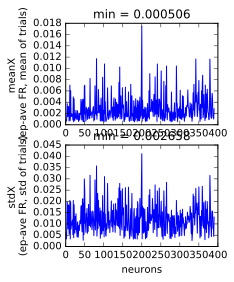

In [30]:
# Set final X and Y (for SVM training) by excluding nan trials and non-active neurons. Also do feature normalization

'''
#dirName = 'SVM_151102_001-002_ch2-PnevPanResults-160624-113108';
dirName = 'SVM_151029_003_ch2-PnevPanResults-160426-191859';
#dirName = '/home/farznaj/Shares/Churchland/data/fni17/imaging/151022/XY_fni17_151022 XY_lassoSVM.mat';
Data = scio.loadmat(dirName, variable_names=['X', 'Y', 'time_aligned_stim', 'non_filtered', 'traces_al_1stSideTry', 'time_aligned_stim_1stSideTry']);
X = Data.pop('X').astype('float')
Y = np.squeeze(Data.pop('Y')).astype('int')
time_aligned_stim = np.squeeze(Data.pop('time_aligned_stim')).astype('float')
Xt = Data.pop('non_filtered').astype('float')
Xt_choiceAl = Data.pop('traces_al_1stSideTry').astype('float')
time_aligned_1stSide = np.squeeze(Data.pop('time_aligned_stim_1stSideTry')).astype('float')
'''

# Identify nan trials
trsExcluded = (np.sum(np.isnan(spikeAveEp0), axis = 1) + np.isnan(choiceVec0)) != 0 # NaN trials # trsExcluded
# sum(trsExcluded)

# Exclude nan trials
X = spikeAveEp0[~trsExcluded,:]; # trials x neurons
Y = choiceVec0[~trsExcluded];
print '%d high-rate trials, and %d low-rate trials\n' %(np.sum(Y==1), np.sum(Y==0))


# Identify neurons that did not fire in any of the trials (during ep) and then exclude them. Otherwise they cause problem for feature normalization.
# thAct and thTrsWithSpike are parameters that you can play with.

# If it is already saved, load it (the idea is to use the same NsExcluded for all the analyses of a session). Otherwise set it.
svmnowname = 'svmCurrChoice' + '_*-' + pnevFileName[-32:]
svmNowName = glob.glob(os.path.join(os.path.dirname(pnevFileName), svmnowname))
if 0: #np.shape(svmNowName)[0]!=0: # NsExcluded is already set and saved
    print 'loading NsExcluded'
    svmNowName = svmNowName[0]
    Data = scio.loadmat(svmNowName, variable_names=['NsExcluded'])
    NsExcluded = Data.pop('NsExcluded')[0,:].astype('bool')
    NsExcluded = NsExcluded[nt]
else:
    print 'NsExcluded not saved, so setting it here'
    # Set nonActiveNs, ie neurons whose average activity during ep is less than thAct.
    spikeAveEpAveTrs = np.nanmean(spikeAveEp0, axis=0); # 1 x units % response of each neuron averaged across epoch ep and trials.
    # thAct = 5e-4; # 1e-5 #quantile(spikeAveEpAveTrs, .1);
    nonActiveNs = spikeAveEpAveTrs < thAct;
    print '\t%d neurons with ave activity in ep < %.5f' %(np.sum(nonActiveNs), thAct)
    np.sum(nonActiveNs)

    # Set NsFewTrActiv, ie neurons that are active in very few trials (by active I mean average activity during epoch ep)
    # thTrsWithSpike = 1; # 3; # ceil(thMinFractTrs * size(spikeAveEp0,1)); % 30  % remove neurons with activity in <thSpTr trials.
    nTrsWithSpike = np.sum(X > thAct, axis=0) # 0 # shows for each neuron, in how many trials the activity was above 0.
    NsFewTrActiv = (nTrsWithSpike < thTrsWithSpike) # identify neurons that were active fewer than thTrsWithSpike.
    print '\t%d neurons are active in < %i trials' %(np.sum(NsFewTrActiv), thTrsWithSpike)

    # Now set the final NxExcluded: (neurons to exclude)
    NsExcluded = (NsFewTrActiv + nonActiveNs)!=0


print '%d = Final # non-active neurons' %(sum(NsExcluded))
# a = size(spikeAveEp0,2) - sum(NsExcluded);
print '\toriginal # neurons = %d; fraction excluded = %.2f\n' %(np.shape(spikeAveEp0)[1], sum(NsExcluded)/float(np.shape(spikeAveEp0)[1]))


# Check what fraction of inhibitRois are excluded, compare with excitatory neurons.
print '%i, %i, %i: #original inh, excit, unsure' %(np.sum(inhibitRois==1), np.sum(inhibitRois==0), np.sum(np.isnan(inhibitRois)))
print '%i, %i, %i: #excluded inh, excit, unsure' %(np.sum(inhibitRois[NsExcluded]==1), np.sum(inhibitRois[NsExcluded]==0), np.sum(np.isnan(inhibitRois[NsExcluded])))
print '%.2f, %.2f, %.2f: fraction excluded inh, excit, unsure\n' %(np.sum(inhibitRois[NsExcluded]==1)/float(np.sum(inhibitRois==1)), np.sum(inhibitRois[NsExcluded]==0)/float(np.sum(inhibitRois==0)), np.sum(np.isnan(inhibitRois[NsExcluded]))/float(np.sum(np.isnan(inhibitRois))))



# Exclude non-active neurons (ie neurons that don't fire in any of the trials during ep)
X = X[:,~NsExcluded]



if windowAvgFlg==0:
    a = np.transpose(traces_al_stim[ep,:,:][:,~NsExcluded,:][:,:,~trsExcluded], (0,2,1))  # ep_frames x trials x units
    X = np.reshape(a, (ep.shape[0]*(~trsExcluded).sum(), (~NsExcluded).sum())) # (ep_frames x trials) x units

    Y = np.tile(np.reshape(choiceVec0[~trsExcluded], (1,-1)), (ep.shape[0], 1)).flatten()    


numDataPoints = X.shape[0] 
print '# data points = %d' %numDataPoints
# print np.shape(X), np.shape(Y)
numTrials = (~trsExcluded).sum()
numNeurons = (~NsExcluded).sum()
# numTrials, numNeurons = X.shape
print '%d trials; %d neurons' %(numTrials, numNeurons)
# print ' The data has %d frames recorded from %d neurons at %d trials' %Xt.shape
# print(X.shape)
# print(Y.shape)


# Handle imbalance in the number of trials:
# unlike matlab, it doesn't seem to be a problem here... so we don't make trial numbers of HR and LR the same.



# Feature normalization and scaling: to remove effects related to scaling and bias of each neuron, we need to zscore data (i.e., make data mean 0 and variance 1 for each neuron) 
meanX = np.mean(X, axis = 0);
stdX = np.std(X, axis = 0);
# normalize X
X = (X-meanX)/stdX;


plt.figure
plt.subplot(2,2,1)
plt.plot(meanX)
plt.ylabel('meanX \n(ep-ave FR, mean of trials)')
plt.title('min = %.6f' %(np.min(meanX)))

plt.subplot(2,2,3)
plt.plot(stdX)
plt.ylabel('stdX \n(ep-ave FR, std of trials)')
plt.xlabel('neurons')
plt.title('min = %.6f' %(np.min(stdX)))


## Set the traces that will be used for projections and plotting 
    Traces are of size (frames x neurons x trials)
    Choose trials that will be used for projections (trs4project = 'trained', 'all', 'corr', 'incorr')
    Remove non-active neurons
    Do feature normalization and scaling for the traces (using mean and sd of X)

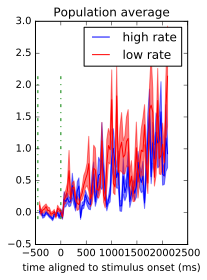

In [10]:
# trs4project = 'incorr' # 'trained', 'all', 'corr', 'incorr'

Data = scio.loadmat(postName, variable_names=['outcomes', 'allResp_HR_LR'])
choiceVecAll = (Data.pop('allResp_HR_LR').astype('float'))[0,:]

# Set trials that will be used for projection traces

if trs4project=='all': 
    Xt = traces_al_stim
    Xt_choiceAl = traces_al_1stSide
    Xt_goAl = traces_al_go
    Xt_rewAl = traces_al_rew
    Xt_incorrRespAl = traces_al_incorrResp
    Xt_initAl = traces_al_init
    Xt_stimAl_all = traces_al_stimAll
    choiceVecNow = choiceVecAll

elif trs4project=='trained':
    Xt = traces_al_stim[:, :, ~trsExcluded];
    Xt_choiceAl = traces_al_1stSide[:, :, ~trsExcluded];
    Xt_goAl = traces_al_go[:, :, ~trsExcluded];
    Xt_rewAl = traces_al_rew[:, :, ~trsExcluded];
    Xt_incorrRespAl = traces_al_incorrResp[:, :, ~trsExcluded];
    Xt_initAl = traces_al_init[:, :, ~trsExcluded];
    Xt_stimAl_all = traces_al_stimAll[:, :, ~trsExcluded];
    choiceVecNow = Y
    
elif trs4project=='corr':
    Xt = traces_al_stim[:, :, outcomes==1];
    Xt_choiceAl = traces_al_1stSide[:, :, outcomes==1];
    Xt_goAl = traces_al_go[:, :, outcomes==1];
    Xt_rewAl = traces_al_rew[:, :, outcomes==1];
    Xt_incorrRespAl = traces_al_incorrResp[:, :, outcomes==1];
    Xt_initAl = traces_al_init[:, :, outcomes==1];
    Xt_stimAl_all = traces_al_stimAll[:, :, outcomes==1];
    choiceVecNow = choiceVecAll[outcomes==1]
    
elif trs4project=='incorr':
    Xt = traces_al_stim[:, :, outcomes==0];
    Xt_choiceAl = traces_al_1stSide[:, :, outcomes==0];
    Xt_goAl = traces_al_go[:, :, outcomes==0];
    Xt_rewAl = traces_al_rew[:, :, outcomes==0];
    Xt_incorrRespAl = traces_al_incorrResp[:, :, outcomes==0];
    Xt_initAl = traces_al_init[:, :, outcomes==0];
    Xt_stimAl_all = traces_al_stimAll[:, :, outcomes==0];
    choiceVecNow = choiceVecAll[outcomes==0]
    
## Xt = traces_al_stim[:, :, np.sum(np.sum(np.isnan(traces_al_stim), axis =0), axis =0)==0];
## Xt_choiceAl = traces_al_1stSide[:, :, np.sum(np.sum(np.isnan(traces_al_1stSide), axis =0), axis =0)==0];



# Exclude non-active neurons (ie neurons that don't fire in any of the trials during ep)
Xt = Xt[:,~NsExcluded,:]
Xt_choiceAl = Xt_choiceAl[:,~NsExcluded,:]
Xt_goAl = Xt_goAl[:,~NsExcluded,:]
Xt_rewAl = Xt_rewAl[:,~NsExcluded,:]
Xt_incorrRespAl = Xt_incorrRespAl[:,~NsExcluded,:]
Xt_initAl = Xt_initAl[:,~NsExcluded,:]
Xt_stimAl_all = Xt_stimAl_all[:,~NsExcluded,:]
    

# Divide data into high-rate (modeled as 1) and low-rate (modeled as 0) trials
hr_trs = (choiceVecNow==1)
lr_trs = (choiceVecNow==0)
# print 'Projection traces have %d high-rate trials, and %d low-rate trials' %(np.sum(hr_trs), np.sum(lr_trs))
    
    
## Feature normalization and scaling

# normalize stim-aligned traces
T, N, C = Xt.shape
Xt_N = np.reshape(Xt.transpose(0 ,2 ,1), (T*C, N), order = 'F')
Xt_N = (Xt_N-meanX)/stdX
Xt = np.reshape(Xt_N, (T, C, N), order = 'F').transpose(0 ,2 ,1)

# normalize goTome-aligned traces
Tg, Ng, Cg = Xt_goAl.shape
Xtg_N = np.reshape(Xt_goAl.transpose(0 ,2 ,1), (Tg*Cg, Ng), order = 'F')
Xtg_N = (Xtg_N-meanX)/stdX
Xtg = np.reshape(Xtg_N, (Tg, Cg, Ng), order = 'F').transpose(0 ,2 ,1)

# normalize choice-aligned traces
Tc, Nc, Cc = Xt_choiceAl.shape
Xtc_N = np.reshape(Xt_choiceAl.transpose(0 ,2 ,1), (Tc*Cc, Nc), order = 'F')
Xtc_N = (Xtc_N-meanX)/stdX
Xtc = np.reshape(Xtc_N, (Tc, Cc, Nc), order = 'F').transpose(0 ,2 ,1)

# normalize reward-aligned traces
Tr, Nr, Cr = Xt_rewAl.shape
Xtr_N = np.reshape(Xt_rewAl.transpose(0 ,2 ,1), (Tr*Cr, Nr), order = 'F')
Xtr_N = (Xtr_N-meanX)/stdX
Xtr = np.reshape(Xtr_N, (Tr, Cr, Nr), order = 'F').transpose(0 ,2 ,1)

# normalize commitIncorrect-aligned traces
Tp, Np, Cp = Xt_incorrRespAl.shape
Xtp_N = np.reshape(Xt_incorrRespAl.transpose(0 ,2 ,1), (Tp*Cp, Np), order = 'F')
Xtp_N = (Xtp_N-meanX)/stdX
Xtp = np.reshape(Xtp_N, (Tp, Cp, Np), order = 'F').transpose(0 ,2 ,1)

# normalize stimAll-aligned traces
Tsa, Nsa, Csa = Xt_stimAl_all.shape
Xtsa_N = np.reshape(Xt_stimAl_all.transpose(0 ,2 ,1), (Tsa*Csa, Nsa), order = 'F')
Xtsa_N = (Xtsa_N-meanX)/stdX
Xtsa = np.reshape(Xtsa_N, (Tsa, Csa, Nsa), order = 'F').transpose(0 ,2 ,1)

# normalize init-aligned traces
Ti, Ni, Ci = Xt_initAl.shape
Xti_N = np.reshape(Xt_initAl.transpose(0 ,2 ,1), (Ti*Ci, Ni), order = 'F')
Xti_N = (Xti_N-meanX)/stdX
Xti = np.reshape(Xti_N, (Ti, Ci, Ni), order = 'F').transpose(0 ,2 ,1)    

np.shape(Xt)


# window of training (ep)
win = (ep-eventI)*frameLength

# Plot stim-aligned raw averages
plt.figure
plt.subplot(1,2,2)
a1 = np.nanmean(Xt[:, :, hr_trs],  axis=1) # frames x trials (average across neurons)
tr1 = np.nanmean(a1,  axis = 1)
tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.nanmean(Xt[:, :, lr_trs],  axis=1) # frames x trials (average across neurons)
tr0 = np.nanmean(a0,  axis = 1)
tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
mn = np.concatenate([tr1,tr0]).min()
mx = np.concatenate([tr1,tr0]).max()
plt.plot([win[0], win[0]], [mn, mx], 'g-.') # mark the begining and end of training window
plt.plot([win[-1], win[-1]], [mn, mx], 'g-.')
plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
# plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, lr_trs],  axis = (1, 2)), 'r', label = 'high rate')
# plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, hr_trs],  axis = (1, 2)), 'b', label = 'low rate')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Population average')
plt.legend()

## Identify the best regularization parameter
    Perform 10-fold cross validation to obtain the best regularization parameter
        More specifically: "crossValidateModel" divides data into training and test datasets. It calls linearSVM.py, which does linear SVM using XTrain, and returns percent class loss for XTrain and XTest.
    This procedure gets repeated for numSamples (100 times) for each value of regulariazation parameter. 
    An average across all 100 samples is computed to find the minimum test class loss.
    Best regularization parameter is defined as the smallest regularization parameter whose test-dataset class loss is within mean+sem of minimum test class loss.

In [11]:
# numSamples = 100; # number of iterations for finding the best c (inverse of regularization parameter)

regType = 'l1'
kfold = 10;
if regType == 'l1':
    print 'running l1 svm classification\r' 
#     cvect = 10**(np.arange(-4, 6,0.2))/numTrials;
    cvect = 10**(np.arange(-4, 6,0.2))/numDataPoints;
elif regType == 'l2':
    print 'running l2 svm classification\r' 
    cvect = 10**(np.arange(-4, 6,0.2));

print 'try the following regularization values: \n', cvect

perClassErrorTrain = np.ones((numSamples, len(cvect)))+np.nan;
perClassErrorTest = np.ones((numSamples, len(cvect)))+np.nan;
for s in range(numSamples):
    for i in range(len(cvect)):
        if regType == 'l1':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cvect[i])
        elif regType == 'l2':
            summary =  crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cvect[i])

        perClassErrorTrain[s, i] = summary.perClassErrorTrain;
        perClassErrorTest[s, i] = summary.perClassErrorTest;

meanPerClassErrorTrain = np.mean(perClassErrorTrain, axis = 0);
semPerClassErrorTrain = np.std(perClassErrorTrain, axis = 0)/np.sqrt(numSamples);

meanPerClassErrorTest = np.mean(perClassErrorTest, axis = 0);
semPerClassErrorTest = np.std(perClassErrorTest, axis = 0)/np.sqrt(numSamples);
ix = np.argmin(meanPerClassErrorTest);
cbest = cvect[meanPerClassErrorTest <= (meanPerClassErrorTest[ix]+semPerClassErrorTest[ix])];
cbest = cbest[0]; # best regularization term based on minError+SE criteria

running l1 svm classification
try the following regularization values: 
[  2.63157895e-06   4.17077156e-06   6.61022745e-06   1.04765045e-05
   1.66041406e-05   2.63157895e-05   4.17077156e-05   6.61022745e-05
   1.04765045e-04   1.66041406e-04   2.63157895e-04   4.17077156e-04
   6.61022745e-04   1.04765045e-03   1.66041406e-03   2.63157895e-03
   4.17077156e-03   6.61022745e-03   1.04765045e-02   1.66041406e-02
   2.63157895e-02   4.17077156e-02   6.61022745e-02   1.04765045e-01
   1.66041406e-01   2.63157895e-01   4.17077156e-01   6.61022745e-01
   1.04765045e+00   1.66041406e+00   2.63157895e+00   4.17077156e+00
   6.61022745e+00   1.04765045e+01   1.66041406e+01   2.63157895e+01
   4.17077156e+01   6.61022745e+01   1.04765045e+02   1.66041406e+02
   2.63157895e+02   4.17077156e+02   6.61022745e+02   1.04765045e+03
   1.66041406e+03   2.63157895e+03   4.17077156e+03   6.61022745e+03
   1.04765045e+04   1.66041406e+04]


Best c (inverse of regularization parameter) = 0.00


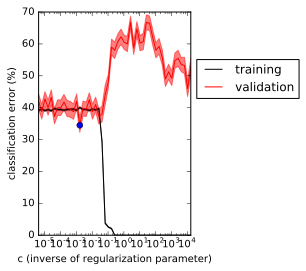

In [12]:
##%%%%%% plot coss-validation results
print 'Best c (inverse of regularization parameter) = %.2f' %cbest
plt.figure('cross validation')
plt.subplot(1,2,1)
plt.fill_between(cvect, meanPerClassErrorTrain-semPerClassErrorTrain, meanPerClassErrorTrain+ semPerClassErrorTrain, alpha=0.5, edgecolor='k', facecolor='k')
plt.fill_between(cvect, meanPerClassErrorTest-semPerClassErrorTest, meanPerClassErrorTest+ semPerClassErrorTest, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(cvect, meanPerClassErrorTrain, 'k', label = 'training')
plt.plot(cvect, meanPerClassErrorTest, 'r', label = 'validation')
plt.plot(cvect[cvect==cbest], meanPerClassErrorTest[cvect==cbest], 'bo')
plt.xlim([cvect[1], cvect[-1]])
plt.xscale('log')
plt.xlabel('c (inverse of regularization parameter)')
plt.ylabel('classification error (%)')
plt.legend(loc='center left', bbox_to_anchor=(1, .7))

## Train SVM model using the best regularization parameter
    All data in X are used for training.
    linear_svm is the trained SVM model that includes weights (w) and intercept (b).

In [13]:
if regType == 'l1':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
elif regType == 'l2':
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l2', dual=True)

linear_svm.fit(X, Y)
    
w = np.squeeze(linear_svm.coef_);
b = linear_svm.intercept_;


Fraction of non-zero weight neurons = 0.00


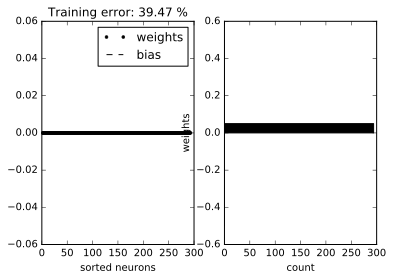

In [14]:
# Plot weights

plt.figure()
plt.subplot(1,2,1)
plt.plot(w[np.argsort(abs(w))[::-1]], 'k.', label = 'weights')
plt.plot(np.ones(len(w))*b, 'k--', label = 'bias')
plt.xlabel('sorted neurons')
plt.legend()
plt.title(('Training error: %.2f %%' %(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)))

plt.subplot(1,2,2)
plt.hist(w, 20,orientation='horizontal', color = 'k')
plt.ylabel('weights')
plt.xlabel('count')

# print abs(((np.dot(X,w)+b)>0).astype('float')-Y.astype('float')).sum()/len(Y)*100 # this is the prediction formula
print 'Fraction of non-zero weight neurons = %.2f' %(np.mean(w!=0))



# Compare weights of inhibitory and excitatory neurons
if neuronType==2:
    # Load inhibitRois
#     Data = scio.loadmat(moreName, variable_names=['inhibitRois'])
#     inhibitRois = Data.pop('inhibitRois')[0,:]

    inhRois = inhibitRois[~NsExcluded]
    print '#inhibit = %d, #excit = %d' %(np.sum(inhRois==1), np.sum(inhRois==0))

    plt.figure()
    plt.subplot(2,2,3)
    plt.plot(w[inhRois==1], label = 'inhibit')
    plt.plot(w[inhRois==0], label = 'excit')
    plt.ylabel('Weights')
    plt.legend(loc='center left', bbox_to_anchor=(1, .7))
    print 'mean(w)_inhibit = %.3f  mean(w)_excit = %.3f' %(np.mean(w[inhRois==1]), np.mean(w[inhRois==0]))

    h, p = stats.ttest_ind(w[inhRois==1], w[inhRois==0])
    print 'p-val_2tailed (inhibit vs excit weights) = %.2f' %p
    # p_tl = ttest2(w[inhRois==1], w[inhRois==0], tail='left')
    # print 'p-val_left_tailed (inhibit vs excit weights) = %.2f' %p_tl


In [15]:
# Do inhibitory and excitatory neurons carry info about choice at different degrees?

if neuronType==2:
    # compute prediction error when setting weights of n excitatory neurons to 0, where n = number of inhibitory neurons
    numShuffles = 100
    train_err = []
    lenInh = (inhRois==1).sum()
    excI = np.argwhere(inhRois==0)

    for i in range(numShuffles):
        linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
        linear_svm.fit(X, Y)  
        w = np.squeeze(linear_svm.coef_);

        # set weights of random sets of excit neurons (of size equal to length of inhibit neurons) to 0.
        en = rng.permutation(excI)[1:lenInh]
        w[en] = 0

        linear_svm.coef_ = w.reshape(1,-1)

        # print 'Training error: %.2f %%' %(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)
        train_err.append(abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100)



    # compute prediction error when setting weights of inhibitory neurons to 0
    linear_svm = svm.LinearSVC(C = cbest, loss='squared_hinge', penalty='l1', dual=False)
    linear_svm.fit(X, Y)  
    w = np.squeeze(linear_svm.coef_);

    w[inhRois==1] = 0 # set weights of inhibit Ns to 0
    # w[inhRois==0] = 0 # set weights of excit Ns to 0
    linear_svm.coef_ = w.reshape(1,-1)

    train_err_inh0 = abs(linear_svm.predict(X)-Y.astype('float')).sum()/len(Y)*100



    # plot the results
    h, p = stats.ttest_1samp(train_err, train_err_inh0)

    plt.figure()
    plt.subplot(2,2,1)
    plt.hist(train_err, np.arange(0,100,3), color = 'k', label = 'data');
    plt.xlabel('training error when setting n excit weights to 0, n=#inhibit neurons')
    plt.ylabel('count')
    plt.title('train_err_inh = %.2f\nmean(train_err_excit) = %.2f\np_val(train_err: excit vs inhibit) = %.2f' %(train_err_inh0, np.mean(train_err), p))


## Null distribution using shuffles
    Compute distritbutions of class loss for train and test datasets by fitting SVM for 100 times.
    Do this for both actual data and shuffled data (ie data in which Y is shuffled but X is not to serve as null distribution.)


In [16]:
numShuffles = 100
summary_data = [];
summary_shfl = [];
perClassErrorTrain_data = [];
perClassErrorTest_data = []
perClassErrorTrain_shfl = [];
perClassErrorTest_shfl = [];
w_data = []
b_data = []
w_shfl = []
b_shfl = []
permIxsList = [];
for i in range(numShuffles):
#     permIxs = rng.permutation(numTrials);
    permIxs = rng.permutation(numDataPoints);
    permIxsList.append(permIxs);
    if regType == 'l1':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l1 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l1 = cbest))
    elif regType == 'l2':
        summary_data.append(crossValidateModel(X, Y, linearSVM, kfold = kfold, l2 = cbest))
        summary_shfl.append(crossValidateModel(X, Y[permIxs], linearSVM, kfold = kfold, l2 = cbest))
        
    perClassErrorTrain_data.append(summary_data[i].perClassErrorTrain);
    perClassErrorTest_data.append(summary_data[i].perClassErrorTest);
    w_data.append(np.squeeze(summary_data[i].model.coef_));
    b_data.append(summary_data[i].model.intercept_);
        
    perClassErrorTrain_shfl.append(summary_shfl[i].perClassErrorTrain);
    perClassErrorTest_shfl.append(summary_shfl[i].perClassErrorTest);
    w_shfl.append(np.squeeze(summary_shfl[i].model.coef_));
    b_shfl.append(summary_shfl[i].model.intercept_);

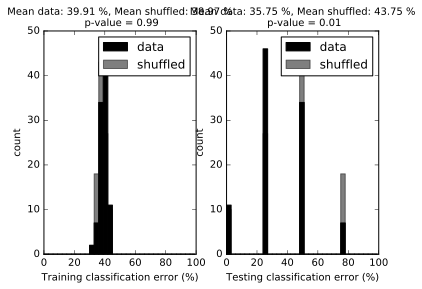

In [17]:
# Plot the histograms

binEvery = 3; # bin width
pvalueTrain = ttest2(perClassErrorTrain_data, perClassErrorTrain_shfl, tail = 'left');
pvalueTest = ttest2(perClassErrorTest_data, perClassErrorTest_shfl, tail = 'left');

plt.figure()
plt.subplot(1,2,1)
plt.hist(perClassErrorTrain_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTrain_shfl, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
plt.xlabel('Training classification error (%)')
plt.ylabel('count')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(perClassErrorTrain_data), np.mean(perClassErrorTrain_shfl), pvalueTrain), fontsize = 10)
plt.legend()

plt.subplot(1,2,2)
plt.hist(perClassErrorTest_data, np.arange(0,100,binEvery), color = 'k', label = 'data');
plt.hist(perClassErrorTest_shfl, np.arange(0,100,binEvery), color = 'k', alpha=.5, label = 'shuffled');
plt.legend()
plt.xlabel('Testing classification error (%)')
plt.title('Mean data: %.2f %%, Mean shuffled: %.2f %%\n p-value = %.2f' %(np.mean(perClassErrorTest_data), np.mean(perClassErrorTest_shfl), pvalueTest), fontsize = 10)
plt.ylabel('count')

## Project traces onto SVM weights
    Stimulus-aligned, choice-aligned, etc traces projected onto SVM fitted weights.
    More specifically, project traces of all trials onto normalized w (ie SVM weights computed from fitting model using X and Y of all trials).

In [18]:
# w = np.zeros(numNeurons)

w_normalized = w/sci.linalg.norm(w);

# stim-aligned traces
# XtN_w = np.dot(Xt_N, w_normalized);
# Xt_w = np.reshape(XtN_w, (T,C), order='F');
# I think below can replace above, test it....
XtN_w = np.dot(Xtsa_N, w_normalized);
Xt_w = np.reshape(XtN_w, (Tsa,Csa), order='F');


# goTone-aligned 
XtgN_w = np.dot(Xtg_N, w_normalized);
Xtg_w = np.reshape(XtgN_w, (Tg,Cg), order='F');

# choice-aligned 
XtcN_w = np.dot(Xtc_N, w_normalized);
Xtc_w = np.reshape(XtcN_w, (Tc,Cc), order='F');

# reward-aligned 
XtrN_w = np.dot(Xtr_N, w_normalized);
Xtr_w = np.reshape(XtrN_w, (Tr,Cr), order='F');

# incommitResp-aligned 
XtpN_w = np.dot(Xtp_N, w_normalized);
Xtp_w = np.reshape(XtpN_w, (Tp,Cp), order='F');

# initTone-aligned 
XtiN_w = np.dot(Xti_N, w_normalized);
Xti_w = np.reshape(XtiN_w, (Ti,Ci), order='F');

/home/farznaj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


## Plot projections and raw averages of neural population responses

/home/farznaj/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


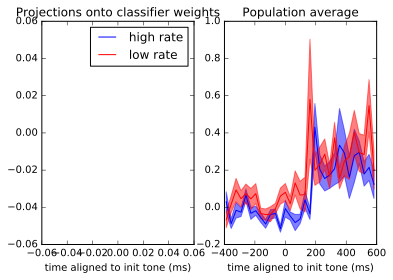

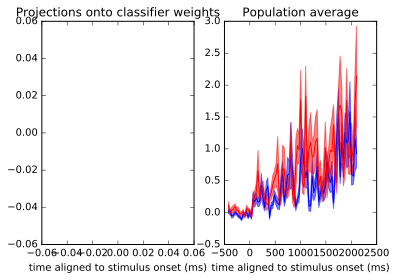

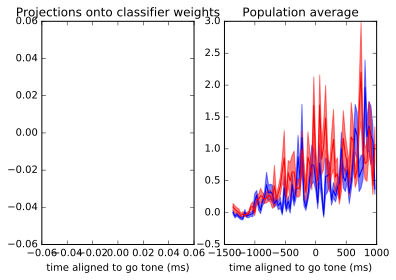

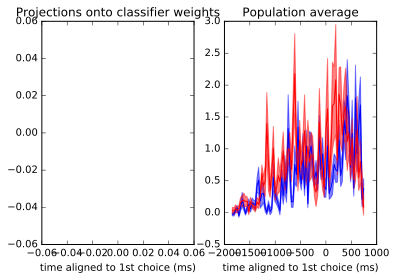

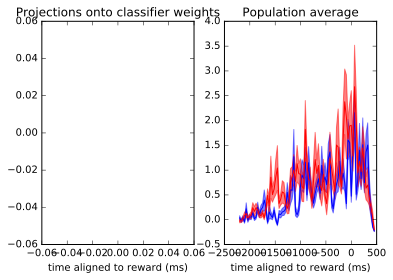

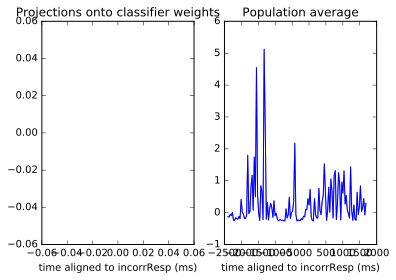

In [19]:
# window of training (ep)
# win = (ep-eventI)*frameLength


# init-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.nanmean(Xti_w[:, hr_trs],  axis = 1)
tr1_se = np.nanstd(Xti_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
tr0 = np.nanmean(Xti_w[:, lr_trs],  axis = 1)
tr0_se = np.nanstd(Xti_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_init, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_init, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_init, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_init, tr0, 'r', label = 'low rate')
# tr1=np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
# tr0=np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
# plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
# plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
plt.xlabel('time aligned to init tone (ms)')
plt.title('Projections onto classifier weights')
plt.legend()

plt.subplot(1,2,2)
a1 = np.nanmean(Xti[:, :, hr_trs],  axis=1) # frames x trials
tr1 = np.nanmean(a1,  axis = 1)
tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.nanmean(Xti[:, :, lr_trs],  axis=1) # frames x trials
tr0 = np.nanmean(a0,  axis = 1)
tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_init, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_init, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_init, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_init, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to init tone (ms)')
plt.title('Population average')
# plt.legend()



# stim-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.nanmean(Xt_w[:, hr_trs],  axis = 1)
tr1_se = np.nanstd(Xt_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
tr0 = np.nanmean(Xt_w[:, lr_trs],  axis = 1)
tr0_se = np.nanstd(Xt_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
mn = np.concatenate([tr1,tr0]).min()
mx = np.concatenate([tr1,tr0]).max()
plt.plot([win[0], win[0]], [mn, mx], 'g-.') # mark the begining and end of training window
plt.plot([win[-1], win[-1]], [mn, mx], 'g-.')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Projections onto classifier weights')
# plt.legend()

plt.subplot(1,2,2)
a1 = np.nanmean(Xt[:, :, hr_trs],  axis=1) # frames x trials (average across neurons)
tr1 = np.nanmean(a1,  axis = 1)
tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.nanmean(Xt[:, :, lr_trs],  axis=1) # frames x trials (average across neurons)
tr0 = np.nanmean(a0,  axis = 1)
tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_stim, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_stim, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_stim, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_stim, tr0, 'r', label = 'low rate')
# plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, lr_trs],  axis = (1, 2)), 'r', label = 'high rate')
# plt.plot(time_aligned_stim, np.nanmean(Xt[:, :, hr_trs],  axis = (1, 2)), 'b', label = 'low rate')
plt.xlabel('time aligned to stimulus onset (ms)')
plt.title('Population average')
# plt.legend()



# goTone-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.nanmean(Xtg_w[:, hr_trs],  axis = 1)
tr1_se = np.nanstd(Xtg_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
tr0 = np.nanmean(Xtg_w[:, lr_trs],  axis = 1)
tr0_se = np.nanstd(Xtg_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_go, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_go, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_go, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_go, tr0, 'r', label = 'low rate')
# tr1=np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
# tr0=np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
# plt.plot(time_aligned_1stSide, tr1, 'r', label = 'high rate')
# plt.plot(time_aligned_1stSide, tr0, 'b', label = 'low rate')
plt.xlabel('time aligned to go tone (ms)')
plt.title('Projections onto classifier weights')
# plt.legend()


plt.subplot(1,2,2)
a1 = np.nanmean(Xtg[:, :, hr_trs],  axis=1) # frames x trials
tr1 = np.nanmean(a1,  axis = 1)
tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.nanmean(Xtg[:, :, lr_trs],  axis=1) # frames x trials
tr0 = np.nanmean(a0,  axis = 1)
tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_go, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_go, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_go, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_go, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to go tone (ms)')
plt.title('Population average')
# plt.legend()



# choice-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.nanmean(Xtc_w[:, hr_trs],  axis = 1)
tr1_se = np.nanstd(Xtc_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
tr0 = np.nanmean(Xtc_w[:, lr_trs],  axis = 1)
tr0_se = np.nanstd(Xtc_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_1stSide, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_1stSide, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_1stSide, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_1stSide, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to 1st choice (ms)')
plt.title('Projections onto classifier weights')
# plt.legend()


plt.subplot(1,2,2)
a1 = np.nanmean(Xtc[:, :, hr_trs],  axis=1) # frames x trials
tr1 = np.nanmean(a1,  axis = 1)
tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.nanmean(Xtc[:, :, lr_trs],  axis=1) # frames x trials
tr0 = np.nanmean(a0,  axis = 1)
tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_1stSide, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_1stSide, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_1stSide, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_1stSide, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to 1st choice (ms)')
plt.title('Population average')
# plt.legend()




# reward-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.nanmean(Xtr_w[:, hr_trs],  axis = 1)
tr1_se = np.nanstd(Xtr_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
tr0 = np.nanmean(Xtr_w[:, lr_trs],  axis = 1)
tr0_se = np.nanstd(Xtr_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_rew, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_rew, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_rew, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_rew, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to reward (ms)')
plt.title('Projections onto classifier weights')
# plt.legend()


plt.subplot(1,2,2)
a1 = np.nanmean(Xtr[:, :, hr_trs],  axis=1) # frames x trials
tr1 = np.nanmean(a1,  axis = 1)
tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.nanmean(Xtr[:, :, lr_trs],  axis=1) # frames x trials
tr0 = np.nanmean(a0,  axis = 1)
tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_rew, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_rew, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_rew, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_rew, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to reward (ms)')
plt.title('Population average')
# plt.legend()




# incommitResp-aligned projections and raw average
plt.figure()
plt.subplot(1,2,1)
tr1 = np.nanmean(Xtp_w[:, hr_trs],  axis = 1)
tr1_se = np.nanstd(Xtp_w[:, hr_trs],  axis = 1) / np.sqrt(numTrials);
tr0 = np.nanmean(Xtp_w[:, lr_trs],  axis = 1)
tr0_se = np.nanstd(Xtp_w[:, lr_trs],  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_incorrResp, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_incorrResp, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_incorrResp, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_incorrResp, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to incorrResp (ms)')
plt.title('Projections onto classifier weights')
# plt.legend()


plt.subplot(1,2,2)
a1 = np.nanmean(Xtp[:, :, hr_trs],  axis=1) # frames x trials
tr1 = np.nanmean(a1,  axis = 1)
tr1_se = np.nanstd(a1,  axis = 1) / np.sqrt(numTrials);
a0 = np.nanmean(Xtp[:, :, lr_trs],  axis=1) # frames x trials
tr0 = np.nanmean(a0,  axis = 1)
tr0_se = np.nanstd(a0,  axis = 1) / np.sqrt(numTrials);
plt.fill_between(time_aligned_incorrResp, tr1-tr1_se, tr1+tr1_se, alpha=0.5, edgecolor='b', facecolor='b')
plt.fill_between(time_aligned_incorrResp, tr0-tr0_se, tr0+tr0_se, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_incorrResp, tr1, 'b', label = 'high rate')
plt.plot(time_aligned_incorrResp, tr0, 'r', label = 'low rate')
plt.xlabel('time aligned to incorrResp (ms)')
plt.title('Population average')
# plt.legend()

## Classification accuracy at each time point
    Same trials that went into projection traces will be used here.

In [20]:
# perClassCorr_t = [];
# corrClass = np.ones((T, numTrials)) + np.nan # frames x trials

# temp = Xti # for trial-history you may want to use this:
temp = Xt
nnf, nnu, nnt = temp.shape
corrClass = np.ones((T, nnt)) + np.nan # frames x trials

# if trs4project!='trained':  # onlyTrainedTrs==0: 
#     temp = temp[:,:,~trsExcluded] # make sure it has same size as Y, you need this for svm.predict below. 
for t in range(T):
    trac = np.squeeze(temp[t, :, :]).T # trials x neurons  # stimulus-aligned trace at time t
    corrFract = 1 - abs(linear_svm.predict(trac)-choiceVecNow); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
#     corrFract = 1 - abs(linear_svm.predict(trac)-Y); # trials x 1 # fraction of correct choice classification using stimulus-aligned neural responses at time t and the trained SVM model linear_svm.
    corrClass[t,:] = corrFract # frames x trials % fraction correct classification for all trials
#     perClassCorr_t.append(corrFract.mean()*100) # average correct classification across trials for time point t. Same as np.mean(corrClass, axis=1)    

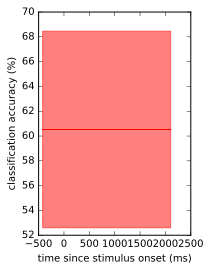

In [21]:
# Plot class accuracy
a = np.mean(corrClass, axis=1)*100 
s = np.std(corrClass, axis=1)*100 /np.sqrt(numTrials);

plt.figure()
plt.subplot(1,2,1)
plt.fill_between(time_aligned_stim, a-s, a+s, alpha=0.5, edgecolor='r', facecolor='r')
plt.plot(time_aligned_stim, a, 'r')
plt.xlabel('time since stimulus onset (ms)')
plt.ylabel('classification accuracy (%)')

## Save results


In [22]:
if trialHistAnalysis:
    ep_ms = np.round((ep-eventI)*frameLength)
    th_stim_dur = []
    svmn = 'svmPrevChoice_%sN_%sITIs_ep%d-%dms_' %(ntName, itiName, ep_ms[0], ep_ms[-1])
else:
    svmn = 'svmCurrChoice_%sN_ep%d-%dms_' %(ntName, ep_ms[0], ep_ms[-1])   
print(svmn)

if saveResults:
    svmName = os.path.join(os.path.dirname(pnevFileName), svmn+os.path.basename(pnevFileName))
    print(svmName)

#     scio.savemat(svmName, {'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'meanX':meanX, 'stdX':stdX, 'thAct':thAct, 'thTrsWithSpike':thTrsWithSpike, 'ep_ms':ep_ms, 'th_stim_dur':th_stim_dur})
    scio.savemat(svmName, {'w':w, 'b':b, 'cbest':cbest, 'corrClass':corrClass, 'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'meanX':meanX, 'stdX':stdX, 'perClassErrorTrain_data':perClassErrorTrain_data, 'perClassErrorTrain_shfl':perClassErrorTrain_shfl, 'perClassErrorTest_data':perClassErrorTest_data, 'perClassErrorTest_shfl':perClassErrorTest_shfl, 'thAct':thAct, 'thTrsWithSpike':thTrsWithSpike, 'ep_ms':ep_ms, 'th_stim_dur':th_stim_dur, 'numSamples':numSamples})

    # save normalized traces as well                       
    # scio.savemat(svmName, {w':w, 'b':b, 'cbest':cbest, 'corrClass':corrClass, 'trsExcluded':trsExcluded, 'NsExcluded':NsExcluded, 'meanX':meanX, 'stdX':stdX, 'X':X, 'Y':Y, 'Xt':Xt, 'Xtg':Xtg, 'Xtc':Xtc, 'Xtr':Xtr, 'Xtp':Xtp})
    # 'linear_svm':linear_svm, 

    # append : doesn't quite work
    # if os.path.isfile(svmName): 
    #     with open(svmName,'ab') as f:
    #         sci.io.savemat(f, {'perClassErrorTrain_data':perClassErrorTrain_data, 'perClassErrorTrain_shfl':perClassErrorTrain_shfl, 'perClassErrorTest_data':perClassErrorTest_data, 'perClassErrorTest_shfl':perClassErrorTest_shfl}) # append
    # else:


svmPrevChoice_excitN_longITIs_ep-453-0ms_
